# Working with trajectories
In this notebook, I want to understand and explore how the output of parcels is structured and see some ways of visualising it.

Created: 03.09.2024

Last edited: 03.09.2024

Created by: Stella Bērziņa

In [1]:
from parcels import FieldSet, Field
from glob import glob
import os
from os.path import join
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cmocean
import gsw
from xgcm.grid import Grid


seconds_per_day = 24 * 60 * 60
deg_to_m = 1852 * 60  # m per degree

In [3]:
# %load_ext autoreload
# %autoreload 2
# # %reload_ext autoreload #if you are doing it again
# import sys

# sys.path.append("../xlcs/")

# import lagrangian_tools as lt
# import grid_calc
# from custommap import *
# from contours import extract_contours

In [2]:


# from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
from numpy import arange, ones
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.cm import get_cmap
from matplotlib import colors 
from matplotlib.colors import ListedColormap
from matplotlib.figure import Figure

from datetime import datetime, timedelta
from netCDF4 import Dataset

import io
import os
import warnings
warnings.filterwarnings("ignore")

# from concurrent.futures import ProcessPoolExecutor
# from concurrent.futures import ThreadPoolExecutor

import dask
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,LatitudeLocator)
import cartopy.feature as cfeature

import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import glob
import intake
from pathlib import Path
import dask
import cmocean.cm as cmo #also for pretty color palettes
import pandas as pd
dask.config.set({"array.slicing.split_large_chunks": True}) 
import sys

# to access intake catalog of eerie
eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")


## Open trajectory file that comes out of parcels

So, from this i understand that even though I can open the whole 

In [3]:
data_xarray = xr.open_zarr("/home/b/b382618/xlcs_stella1/examples/lavd_20020325.zarr")
print(data_xarray)

<xarray.Dataset> Size: 1MB
Dimensions:     (trajectory: 2550, obs: 24)
Coordinates:
  * obs         (obs) int32 96B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * trajectory  (trajectory) int64 20kB 0 1 2 3 4 5 ... 2545 2546 2547 2548 2549
Data variables:
    lat         (trajectory, obs) float32 245kB dask.array<chunksize=(2550, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 245kB dask.array<chunksize=(2550, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 490kB dask.array<chunksize=(2550, 1), meta=np.ndarray>
    vorticity   (trajectory, obs) float32 245kB dask.array<chunksize=(2550, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 245kB dask.array<chunksize=(2550, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        LAVDParticleOutOfBoundAdvectionRK4SampleVorticity
    parcel

In [37]:
print(data_xarray["vorticity"])

<xarray.DataArray 'vorticity' (trajectory: 2550, obs: 24)> Size: 245kB
dask.array<open_dataset-vorticity, shape=(2550, 24), dtype=float32, chunksize=(2550, 1), chunktype=numpy.ndarray>
Coordinates:
  * obs         (obs) int32 96B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * trajectory  (trajectory) int64 20kB 0 1 2 3 4 5 ... 2545 2546 2547 2548 2549
Attributes:
    long_name:      
    standard_name:  vorticity
    units:          unknown


## Currently can't figure out how to see the vorticity values, FIGURE OUT

In [13]:
data_xarray["vorticity"]["trajectory"][10].values

array(10)

In [34]:
np.unique(data_xarray["lon"].values, return_counts=True)

(array([262.     , 262.0008 , 262.0009 , ..., 342.0967 , 342.10605,
        342.10706], dtype=float32),
 array([16977,     1,     1, ...,     1,     1,     1]))

## I still also don't understand how to subset trajectories. it should work with .where() FIGURE OUT

In [35]:
## subset a small set of trajectories to try
sub_data= data_xarray.isel(lat=slice(15,20), lon=slice(262,270)) 
# da.isel(space=0, time=slice(None, 2))

ValueError: Dimensions {'lat', 'lon'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'trajectory': 2873520, 'obs': 19})

In [31]:
sub_data=data_xarray.where(data_xarray['lat']==[90:100])

SyntaxError: invalid syntax (1883714869.py, line 1)

## Figure 1

In [38]:
one_hour = np.timedelta64(1, "h")  # Define timedelta object to help with conversion


x = data_xarray["lon"].values
y = data_xarray["lat"].values
distance = np.cumsum(
    np.sqrt(np.square(np.diff(x)) + np.square(np.diff(y))), axis=1
)  # d = (dx^2 + dy^2)^(1/2)

real_time = data_xarray["time"]  # convert time to hours
time_since_release = (
    real_time.values.transpose() - real_time.values[:, 0]
)  # substract the initial time from each timeseries

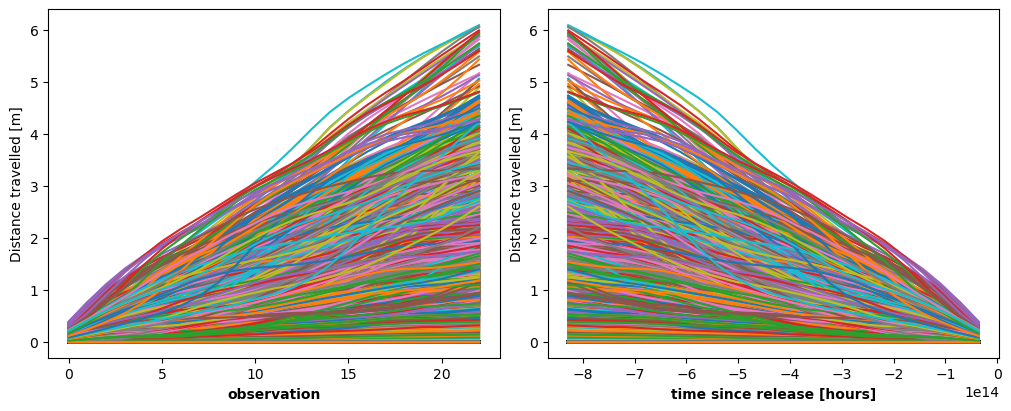

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

ax1.set_ylabel("Distance travelled [m]")
ax1.set_xlabel("observation", weight="bold")
d_plot = ax1.plot(distance.transpose())

ax2.set_ylabel("Distance travelled [m]")
ax2.set_xlabel("time since release [hours]", weight="bold")
d_plot_t = ax2.plot(time_since_release[1:], distance.transpose())
plt.show()

## Figure 2

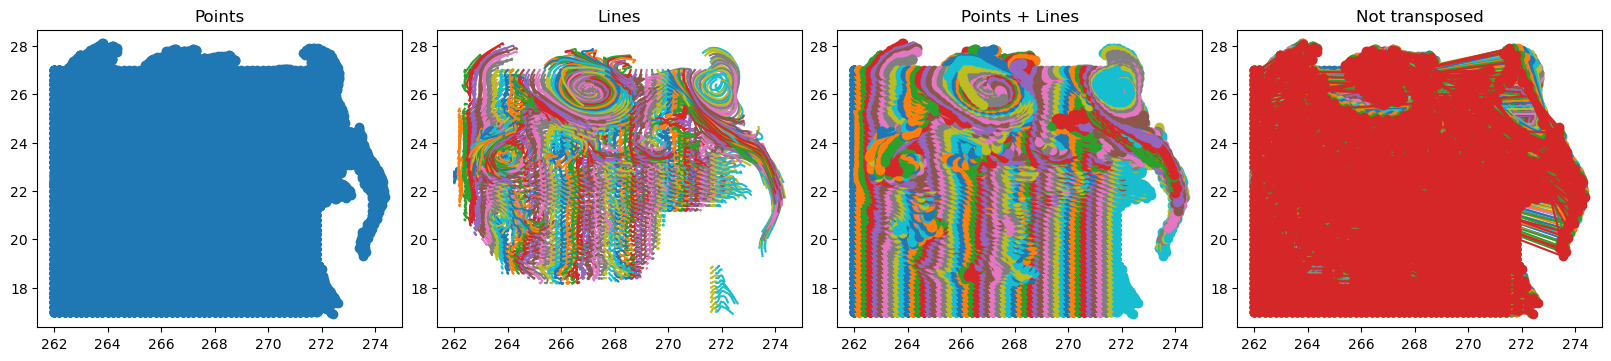

In [40]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    1, 4, figsize=(16, 3.5), constrained_layout=True
)

###-Points-###
ax1.set_title("Points")
ax1.scatter(data_xarray["lon"].T, data_xarray["lat"].T)
###-Lines-###
ax2.set_title("Lines")
ax2.plot(data_xarray["lon"].T, data_xarray["lat"].T)
###-Points + Lines-###
ax3.set_title("Points + Lines")
ax3.plot(data_xarray["lon"].T, data_xarray["lat"].T, marker="o")
###-Not Transposed-###
ax4.set_title("Not transposed")
ax4.plot(data_xarray["lon"], data_xarray["lat"], marker="o")

plt.show()

## Figure 3

<xarray.Dataset> Size: 1MB
Dimensions:     (trajectory: 2550, obs: 24)
Coordinates:
  * obs         (obs) int32 96B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * trajectory  (trajectory) int64 20kB 0 1 2 3 4 5 ... 2545 2546 2547 2548 2549
Data variables:
    lat         (trajectory, obs) float32 245kB dask.array<chunksize=(2550, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 245kB dask.array<chunksize=(2550, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 490kB dask.array<chunksize=(2550, 1), meta=np.ndarray>
    vorticity   (trajectory, obs) float32 245kB dask.array<chunksize=(2550, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 245kB dask.array<chunksize=(2550, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        LAVDParticleOutOfBoundAdvectionRK4SampleVorticity
    parcels_mesh:           spherical
    parcels_version:        3.0.4

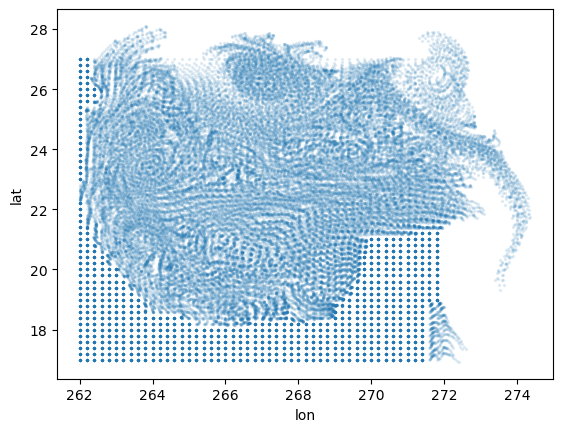

In [42]:
display(data_xarray)
data_xarray.to_dataframe().plot.scatter(x="lon", y="lat", s=2, alpha=0.1);

## Figure 4

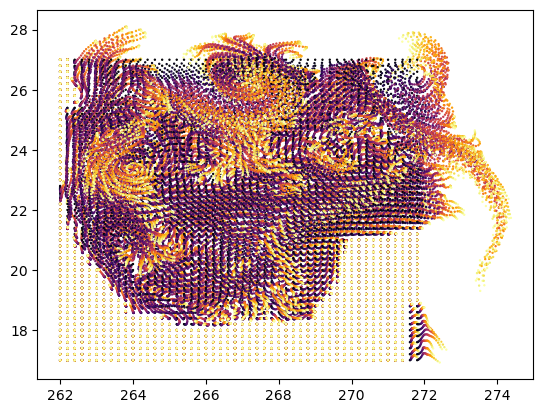

In [27]:
# cb = ax.scatter(x, y, z, c=z, s=20, marker="o")
plt.scatter(data_xarray.lon, data_xarray.lat, c=data_xarray.time, s=0.5, cmap=plt.get_cmap("inferno_r"))
# plt.plot(psetAA.lon, psetAA.lat, "b.", label="Analytical")
# plt.legend()
# plt.show()